# Characterizing vertical stratification in the ocean

Argovis provides an API that indexes and distributes numerous oceanographic datasets with detailed query parameters, enabling you to search and download only and exactly data of interest. 

This notebook guides users in exploring the vertical structure of density in the ocean using ocean observations and gridded products (i.e. products that provide data on a grid starting from sparse point measurements). 

## Learning goals

- Describe differences and similarities between temperature and salinity measurements from Argo floats and ships
- Estimate mixed layer depth from temperature and salinity profiles
- Describe how mixed layer depth varies with latitude
- Estimate vertical stratification from temperature and salinity profiles
- Describe how vertical stratification varies with depth and longitude

## Intro to ocean data of interest

Both Argo and ship based profiles in Argovis are helpful to explore vertical stratification in the ocean. Please read more about these datasets using these links:

- https://argo.ucsd.edu/about/
- https://argo.ucsd.edu/about/status/
- https://argovis.colorado.edu/argo
- https://www.go-ship.org/About.html
- https://www.go-ship.org/RefSecs/goship_ref_secs.html
- https://argovis.colorado.edu/ships

As you read, try and answer the following questions:
- What is the spatial distribution of the observations from Argo versus GO-SHIP? Why?
- What is the temporal distribution of the observations from Argo versus GO-SHIP? Why?

Hint: you can use the Argovis website (https://argovis.colorado.edu/argo and https://argovis.colorado.edu/ships) to explore the spatial and temporal distribution of the observations.

### GO-SHIP Easy Ocean

This product provides a gridded version of GO-SHIP data. Please find more information at https://cchdo.ucsd.edu/products/goship-easyocean.

## Setup: Register an API key

In order to allocate Argovis's limited computing resources fairly, users are encouraged to register and request a free API key. This works like a password that identifies your requests to Argovis. To do so:

 - Visit [https://argovis-keygen.colorado.edu/](https://argovis-keygen.colorado.edu/)
 - Fill out the form under _New Account Registration_
 - An API key will be emailed to you shortly.
 
Treat this API key like a password - don't share it or leave it anywhere public. If you ever forget it or accidentally reveal it to a third party, see the same website above to change or deactivate your token.

Put your API key in the quotes in the variable below before moving on (please note that if you proceed without including anything in the quotes, the notebook may still work, yet it may also give an error):

In [1]:
API_KEY=''

## Setup: import libraries and functions

In [2]:
# Let's start importing libraries and functions we will need
from argovisHelpers import helpers as avh

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt # e.g. to change the size of figures created from functions
import copy

import sys
sys.path.append('./work_in_progress')
# let's import functions from the .py file in the current folder
from Argovis_tasks_helpers import get_route,list_values_for_parameter_to_api_query,show_variable_names_for_collections
from Argovis_tasks_helpers import get_api_output_formatted_list_1var_for_regions_and_timeranges, get_api_output_formatted_list_1var_for_parameter, api_output_formatted_list_1var_plot_lons_lats_map,api_output_formatted_list_1var_plot_profiles,api_output_formatted_list_1var_plot_map,api_output_formatted_list_1var_plot_horizontal_and_time_ave,api_output_formatted_list_parameter_2d_plot
from Argovis_tasks_helpers import api_output_formatted_list_include_gsw_fields

## Setup: define parameters to query data of interest

Let's indicate the collections of interest, i.e. what datasets in Argovis you would like to use as they include the oceanic properties of interest. **Please first run the code with the current settings to familiarize yourself with the notebook: after that, if needed, change the settings and run the notebook again.**

In [3]:
# for a list of collections, please see the Argovis swagger page

#### in the following we set parameters to compare ocean profiles with a gridded product
selection_params = {}

#+++ example to use Argo and cchdo/easyocean profile data, as well as the glodap gridded product (which provides time mean fields)
selection_params['collections']  = ['argo']

#### let's print to screen some info based on the selected collections (to be able to select further parameters in the next cell)
vars_lists = show_variable_names_for_collections(collections_list=selection_params['collections'],API_KEY=API_KEY,verbose=True)


https://argovis-api.colorado.edu/argo/vocabulary?parameter=data
>>>>> argo
['bbp470', 'bbp470_argoqc', 'bbp532', 'bbp532_argoqc', 'bbp700', 'bbp700_2', 'bbp700_2_argoqc', 'bbp700_argoqc', 'bisulfide', 'bisulfide_argoqc', 'cdom', 'cdom_argoqc', 'chla', 'chla_argoqc', 'chla_fluorescence', 'chla_fluorescence_argoqc', 'cndc', 'cndc_argoqc', 'cp660', 'cp660_argoqc', 'down_irradiance380', 'down_irradiance380_argoqc', 'down_irradiance412', 'down_irradiance412_argoqc', 'down_irradiance443', 'down_irradiance443_argoqc', 'down_irradiance490', 'down_irradiance490_argoqc', 'down_irradiance555', 'down_irradiance555_argoqc', 'down_irradiance665', 'down_irradiance665_argoqc', 'down_irradiance670', 'down_irradiance670_argoqc', 'downwelling_par', 'downwelling_par_argoqc', 'doxy', 'doxy2', 'doxy2_argoqc', 'doxy3', 'doxy3_argoqc', 'doxy_argoqc', 'nitrate', 'nitrate_argoqc', 'ph_in_situ_total', 'ph_in_situ_total_argoqc', 'pressure', 'pressure_argoqc', 'salinity', 'salinity_argoqc', 'salinity_sfile', 'sali

Now let's indicate the data of interest within the collections we selected above. As examples, for each collection, we need to specify the variable name and the quality control flag of interest (if a specific qc flag is of interest and if the flag is available for a collection).

In [4]:
#### params varying with the region

#+++ example to use salinity from Argo profile data (with argo qc flag 1) and the Roemmich and Gilson monthly gridded product
selection_params['varnames']     = ['salinity']
selection_params['varnames_qc']  = [',1'] # argoqc = 1 is best quality

# for each collection, indicate the variable names for temperature and salinity (as they will be needed to estimate e.g. density)
selection_params['varname_temperature'] = ['temperature']
selection_params['varname_salinity']    = ['salinity']

# Please indicate extra variables of interest that were not included in the list above
# do not forget to include a comma at the start of the string, e.g. ',salinity,temperature'
selection_params['data_extra']     = [',temperature,1']

# define name of the variable that includes levels for each collection
selection_params['varname_levels'] = ['pressure'] # for the gridded product, the level info is in the metadata, i.e. there is no variable in 'data' (for argo, 'pressure' is within the 'data' instead)

#### Before we continue, let's check that variables selected are included in the corresponding collection selected (if not, we should change the selected variable name in selection_params['varnames'])

In [5]:
for i,ilist in enumerate(vars_lists):
    if selection_params['varnames'][i] not in ilist:
        print('>>>>> '+selection_params['collections'][i]+' does not include selected variable, i.e. '+selection_params['varnames'][i])
        print('Here is a list of the variables that are included:')
        print(ilist)
        change_name_of_selected_variable_before_continuing
    else:
        print('>>>>> '+selection_params['collections'][i]+' includes selected variable, i.e. '+selection_params['varnames'][i])

>>>>> argo includes selected variable, i.e. salinity


Let's now set the regions of interest and the type and tag for each region. Please note that in some regions and time periods of interest, the data of interest may not be available.

Please include more regions of interest using the same format as the current example.

In [6]:
#### params varying with the region

# in this example, we will use the 'box' selection type (i.e. we query the data within boxes),
# hence we indicate here the bottom/left and top/right vertices for each box of interest... 
# the other option is to search in a 'polygon' and indicate the polygon
# vertices in a list (first and last vertex should be the same)

selection_params['regions']     = [
                        [[-28,-60],[-23,-55]],
                        [[-28,-35],[-23,-30]],
                        [[-28,-2.5],[-23,2.5]],
                        [[-28,30],[-23,35]],
                        [[-28,55],[-23,60]],
                        ]
#+++

selection_params['regions_type'] = ['box', 'box', 'box', 'box', 'box', 'box', 'box']

selection_params['regions_tag'] = ['South Atlantic',
                                   'Southern Subtropics Atlantic',
                                   'Near equator Atlantic',
                                   'Northern Subtropics Atlantic',
                                   'North Atlantic',
                                  ]
####



Finally, let's set up the time periods of interest (there could be more than one, e.g. to compare different seasons or different years). We also define the vertical levels that we want to use to interpolate observed profiles and colors to use for the line plots.

In [7]:
# list of startDate and endDates of interest (note: these will not be used for glodap as glodap only provides a time mean)
selection_params['startDate']    = ['2021-06-01T00:00:00Z']
selection_params['endDate']      = ['2021-06-30T00:00:00Z']
# selection_params['endDate']      = ['2022-12-31T00:00:00Z']

#### other params
# custom levels for vertically integrated profiles
selection_params['interp_levels']= list(range(10,500))[0::1]

# levels for vertically integrated profiles if we want to use the vertical axis of one of the grids in Argovis
# selection_params['interp_levels']= 'rg09_temperature_200401_Total' #list(range(10,2001))[0::20]

# colors to use for the line plots
colors = list(mcolors.TABLEAU_COLORS.keys())

In [8]:
# if the user requested to interpolate on the vertical axis on a grid, the code here redefines 'interp_levels'  based on that
if isinstance(selection_params['interp_levels'],str):
    
    meta = avh.query('grids/meta', options={"id": 'rg09_temperature_200401_Total'},apikey=API_KEY, apiroot=get_route(selection_params['interp_levels']),verbose=True)
    selection_params['interp_levels']=meta[0]['levels']
#selection_params['interp_levels']

## Loading the data of interest using the Argovis API

In the next code cell, parameters selected above are used to query the data of interest and format them in a way that allows to easily visualize the data. Depending on how many regions/time periods were selected and the extent of each region/time period of interest, the next code cell may take some time to complete.

In [9]:
api_output_formatted_list = get_api_output_formatted_list_1var_for_regions_and_timeranges(selection_params=selection_params,API_KEY=API_KEY)


>>>>>>>>> argo salinity, South Atlantic 2021-06-01 to 2021-06-30
https://argovis-api.colorado.edu/argo?data=salinity,1,temperature,1&box=[[-28,+-60],+[-23,+-55]]&startDate=2021-06-01T00:00:00Z&endDate=2021-06-30T00:00:00Z
https://argovis-api.colorado.edu/argo?data=salinity,1,temperature,1&box=[[-28,+-60],+[-23,+-55]]&startDate=2021-06-01T00:00:00Z&endDate=2021-06-30T00:00:00Z&compression=minimal
>>>>>>>>> argo salinity, Southern Subtropics Atlantic 2021-06-01 to 2021-06-30
https://argovis-api.colorado.edu/argo?data=salinity,1,temperature,1&box=[[-28,+-35],+[-23,+-30]]&startDate=2021-06-01T00:00:00Z&endDate=2021-06-30T00:00:00Z
https://argovis-api.colorado.edu/argo?data=salinity,1,temperature,1&box=[[-28,+-35],+[-23,+-30]]&startDate=2021-06-01T00:00:00Z&endDate=2021-06-30T00:00:00Z&compression=minimal
>>>>>>>>> argo salinity, Near equator Atlantic 2021-06-01 to 2021-06-30
https://argovis-api.colorado.edu/argo?data=salinity,1,temperature,1&box=[[-28,+-2.5],+[-23,+2.5]]&startDate=2021-06-

## Visualization: map of profile locations in each region and time period of interest

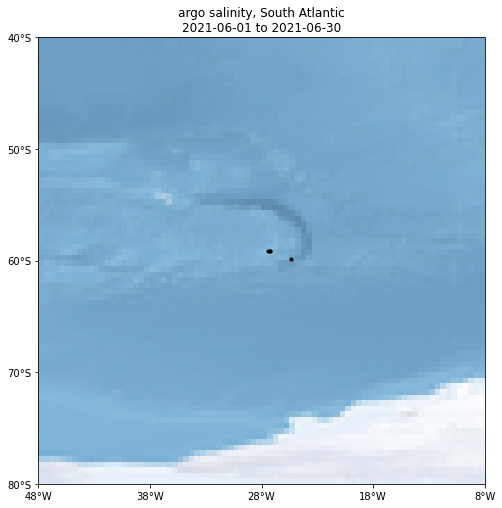

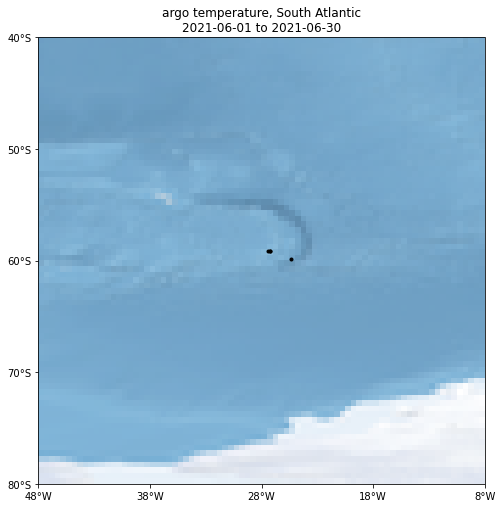

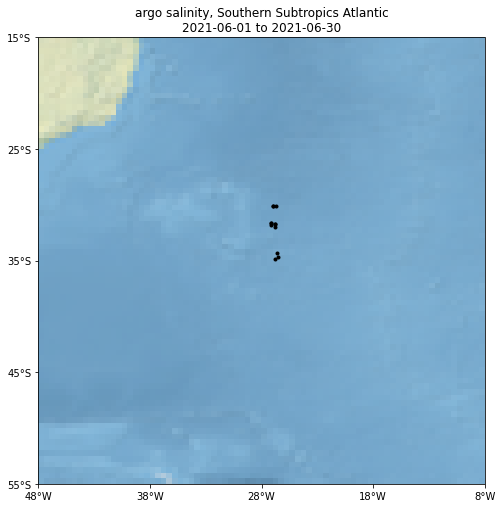

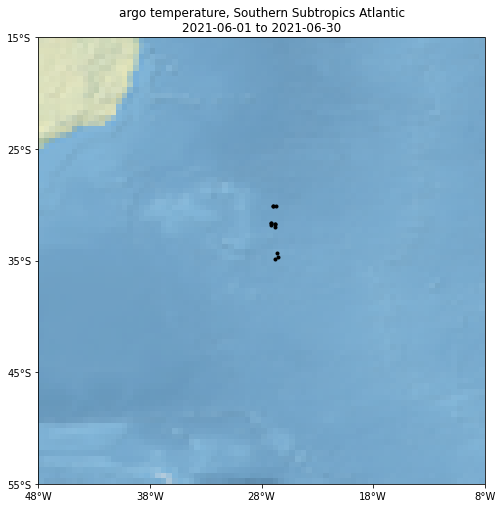

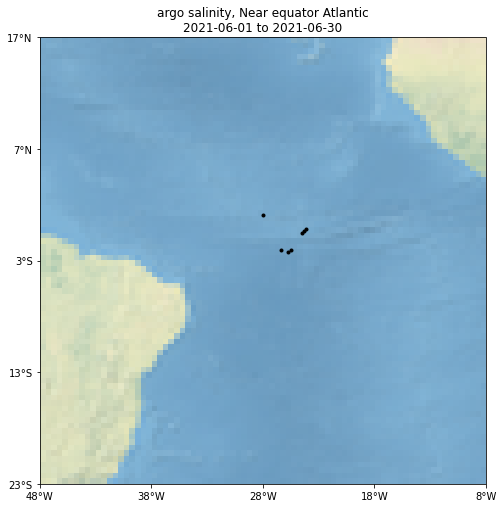

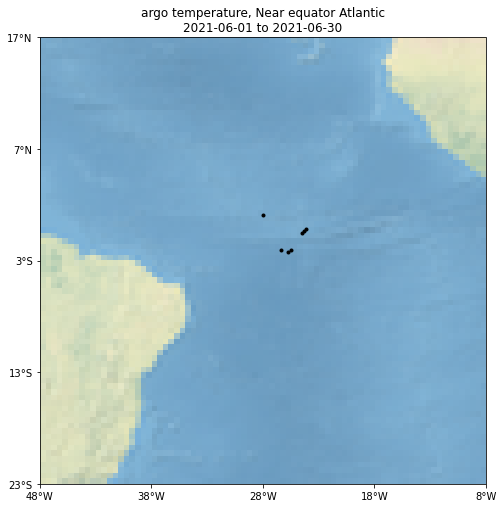

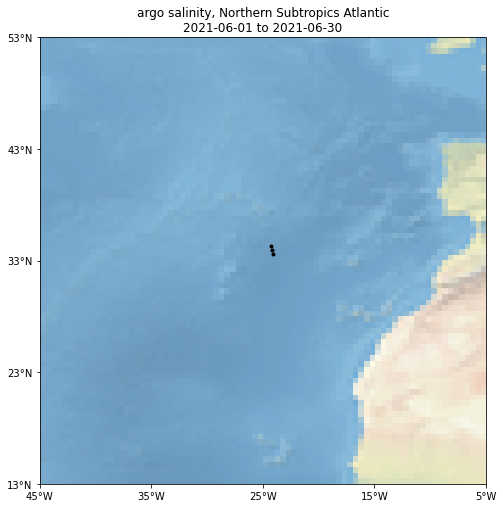

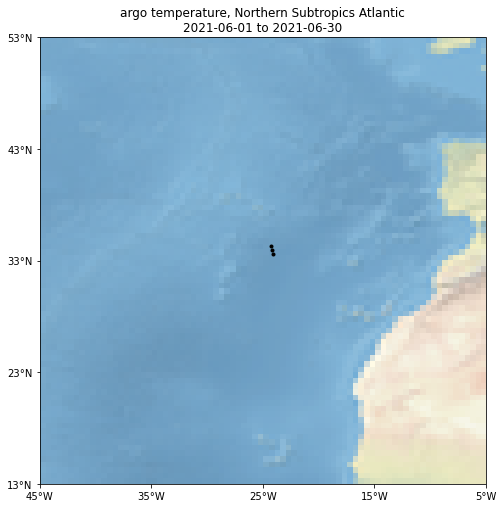

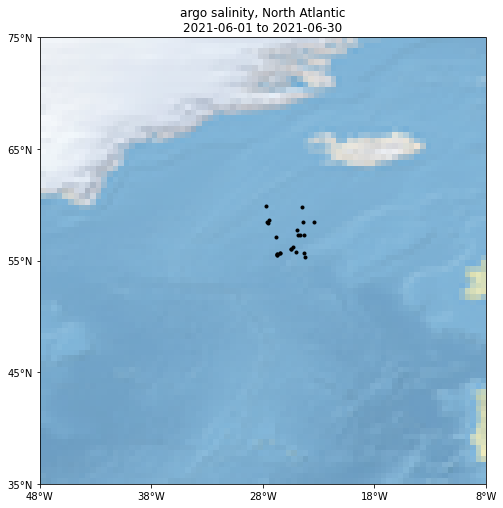

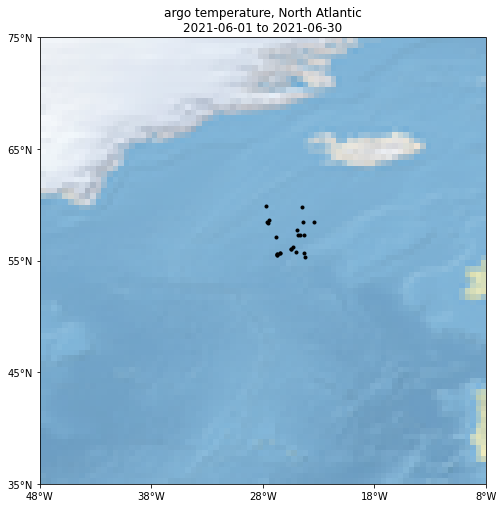

In [10]:
# plot map of lons and lats for data that are not gridded
api_output_formatted_list_1var_plot_lons_lats_map(api_output_formatted_list,flag_map_for_only_one_var=False)      

## Select one profile

Let's select one of the profiles in each region and look at the data. To select the first profile returned by Argovis for each region, leave n=0 in the cell of code below (if you would like to pick another profile, use a different value for n).

In [11]:
# proceed picking only one profile
n = 0;
api_output_formatted_list_1profile = copy.deepcopy(api_output_formatted_list)

for iapi in api_output_formatted_list_1profile:
    for ivar in iapi:
        for ikey in ['_id','data','levels','timestamp','longitude','latitude']:
            if ikey in iapi[ivar].keys():
                iapi[ivar][ikey] = [iapi[ivar][ikey][n]]
        if 'data_xarray' in iapi[ivar].keys():
            iapi[ivar]['data_xarray'] = iapi[ivar]['data_xarray'].isel(index=[n])

Let's compute e.g. potential density and buoyancy frequency squared (N_squared) from in-situ temperature and salinity and add it to items in the list api_output_formatted_list.

In [12]:
api_output_formatted_list_1profile = api_output_formatted_list_include_gsw_fields(list_fields_to_include=['absolute_salinity','conservative_temperature','potential_density','Nsquared'],
                                                        api_output_formatted_list0=api_output_formatted_list_1profile)


## Visualization: plot the profile in each region and time period of interest. 


/Users/dgiglio/Work/code/giglio/Argovis_newAPI/demo_notebooks/work_in_progress/Argovis_tasks_helpers.py:472: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,9))


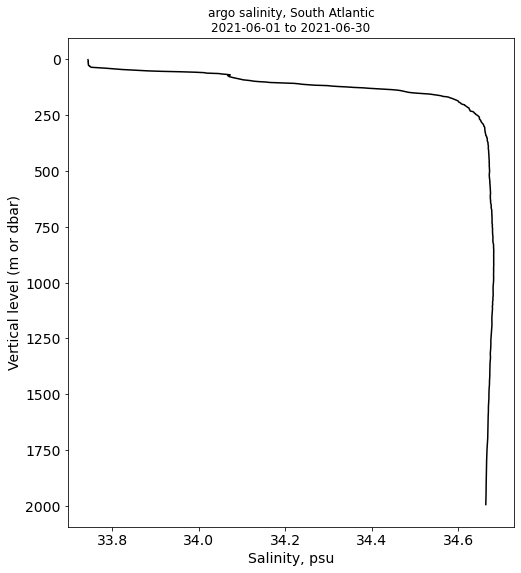

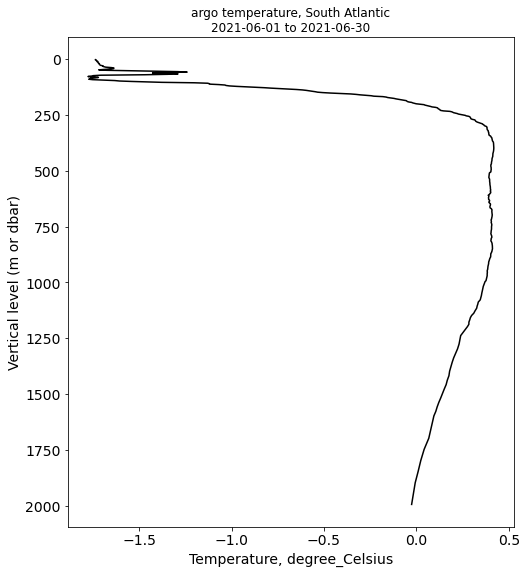

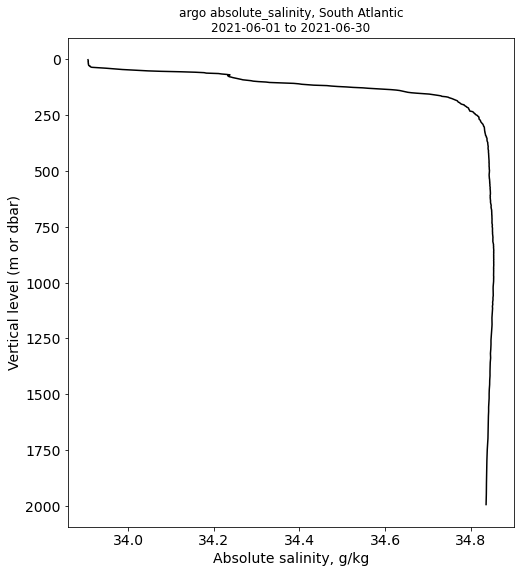

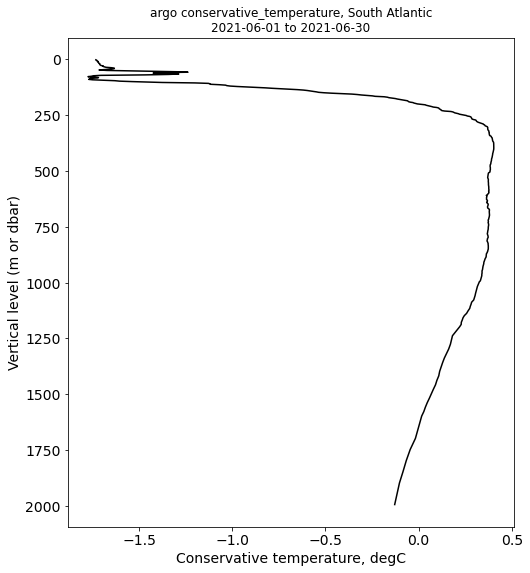

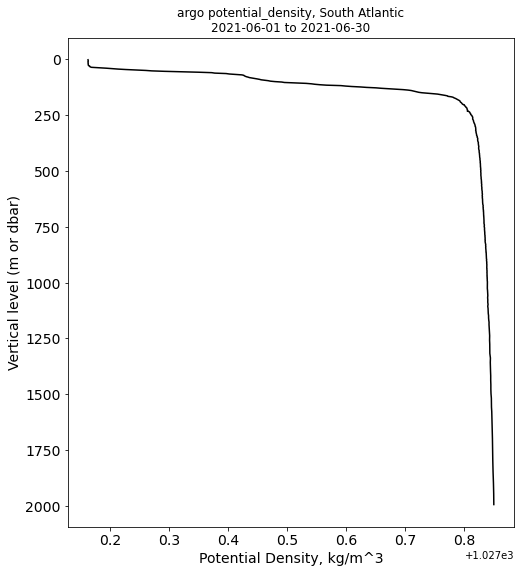

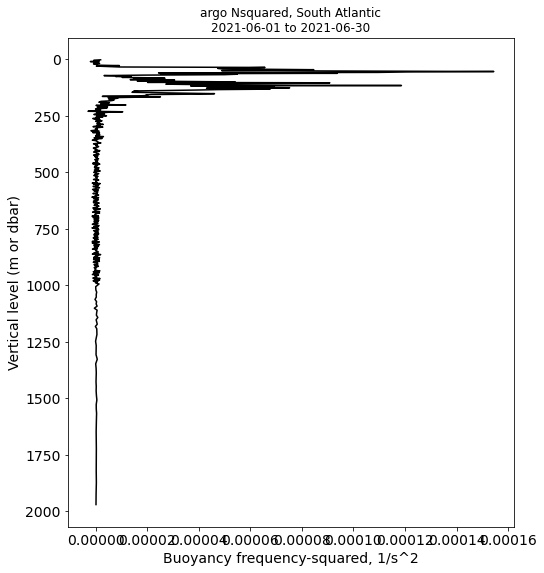

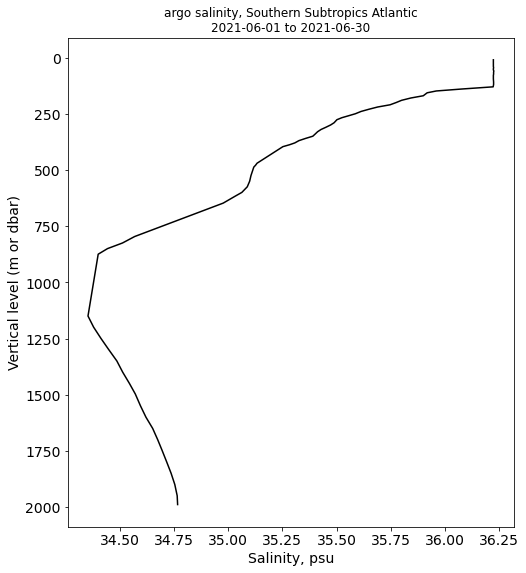

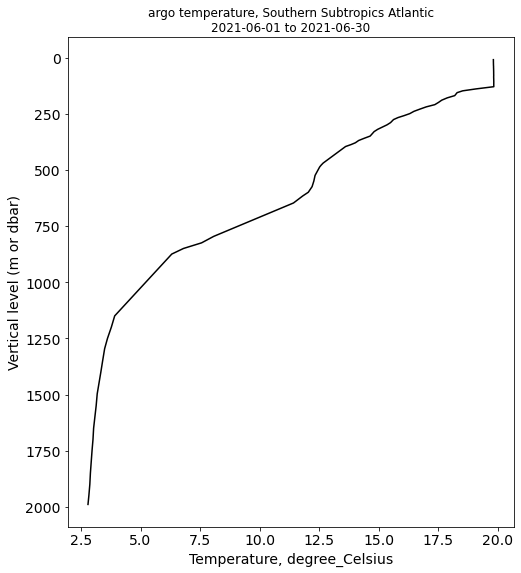

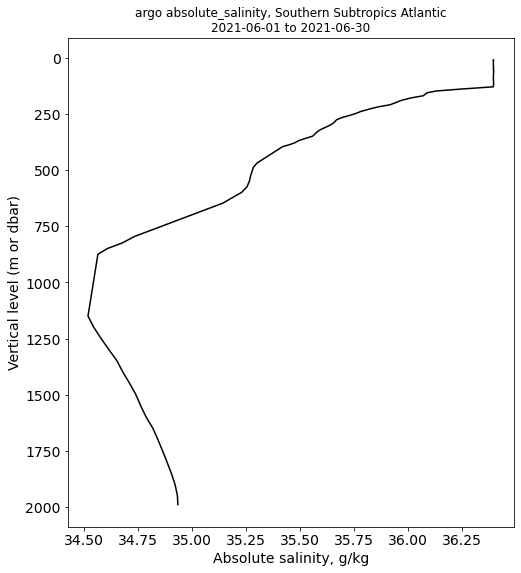

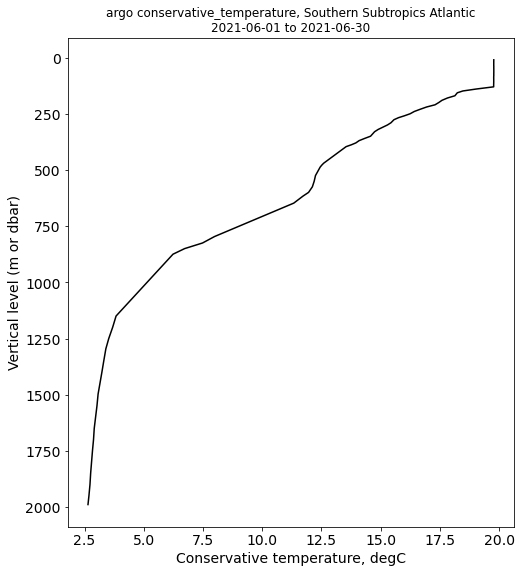

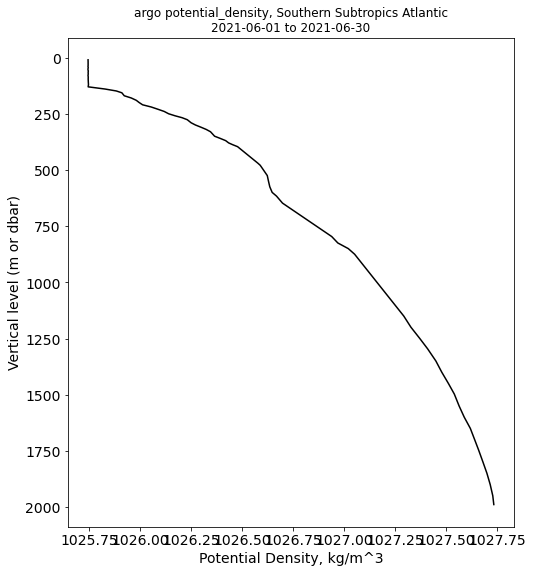

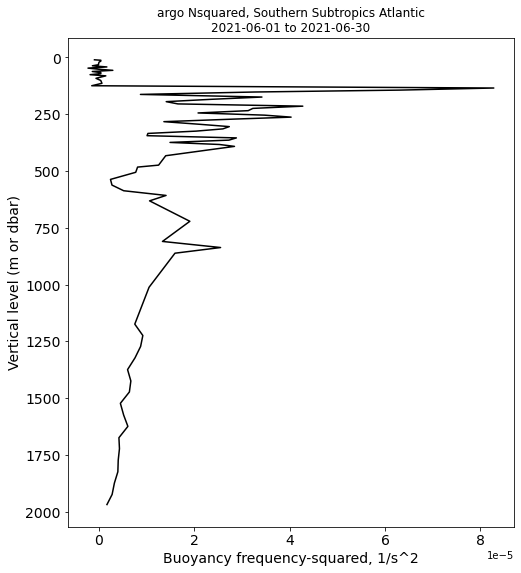

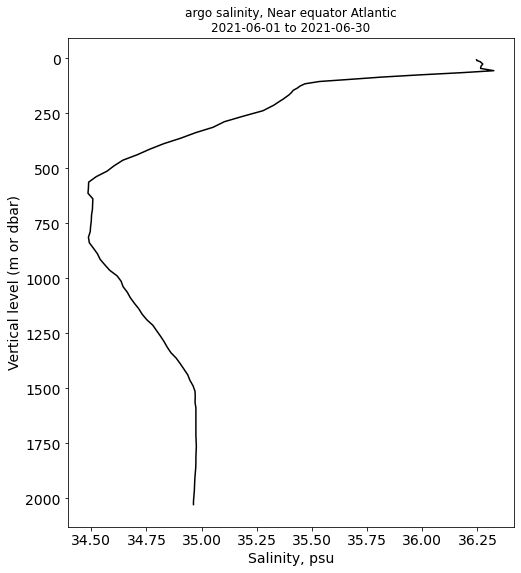

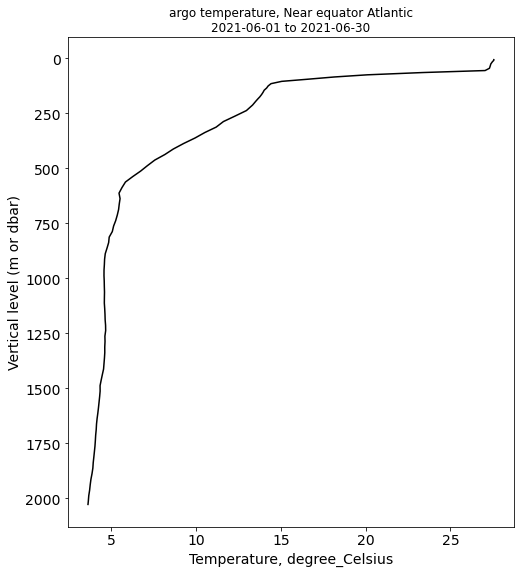

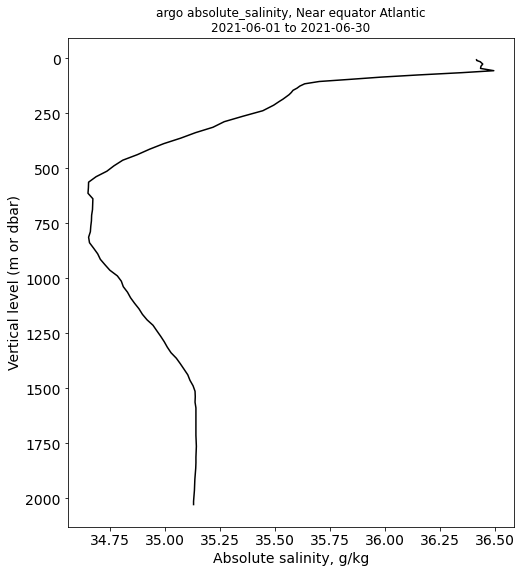

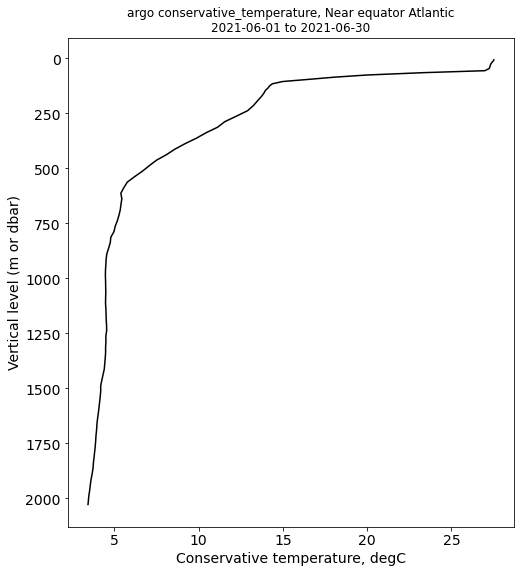

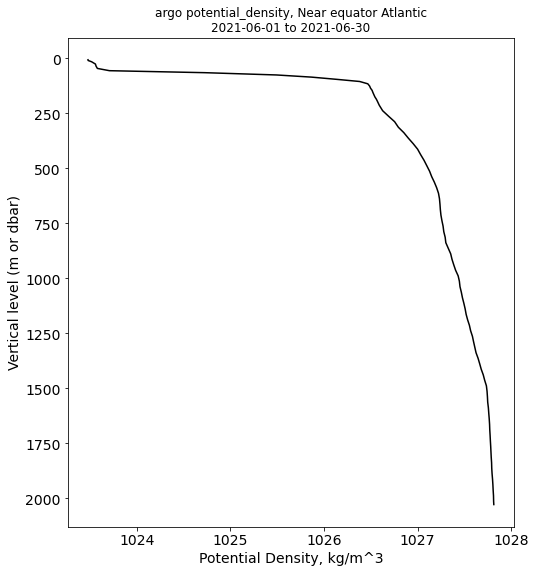

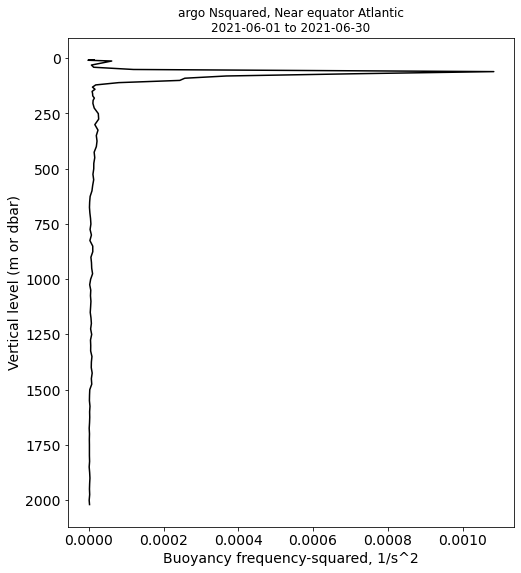

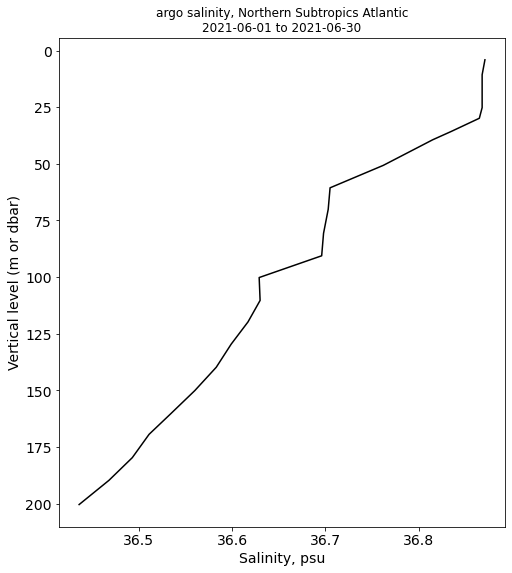

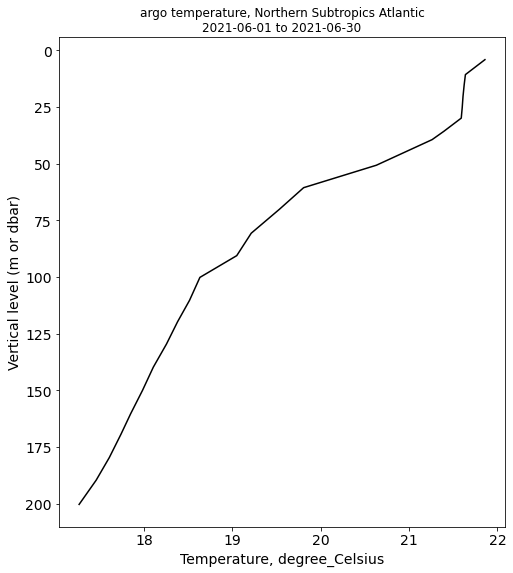

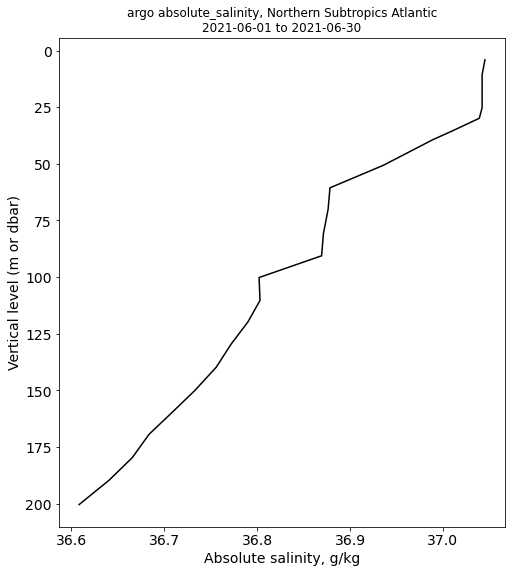

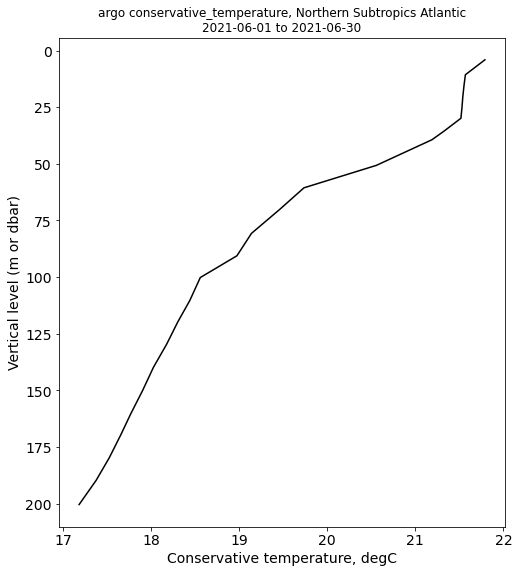

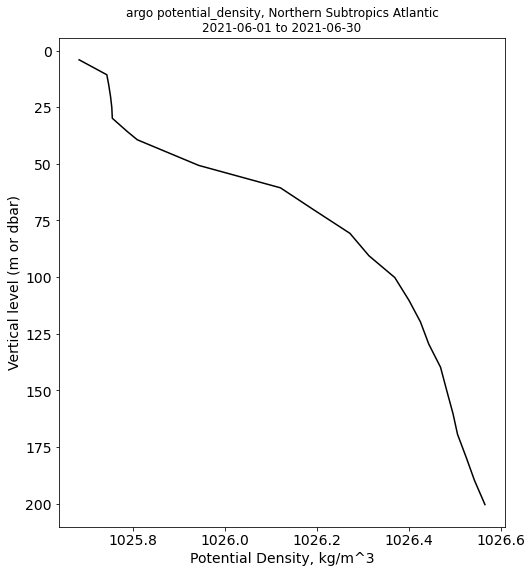

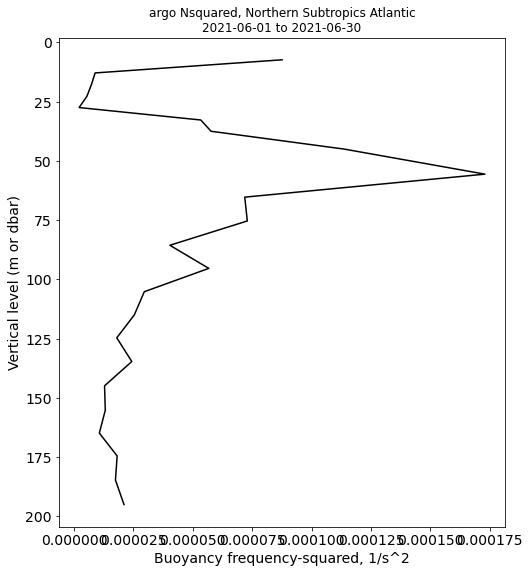

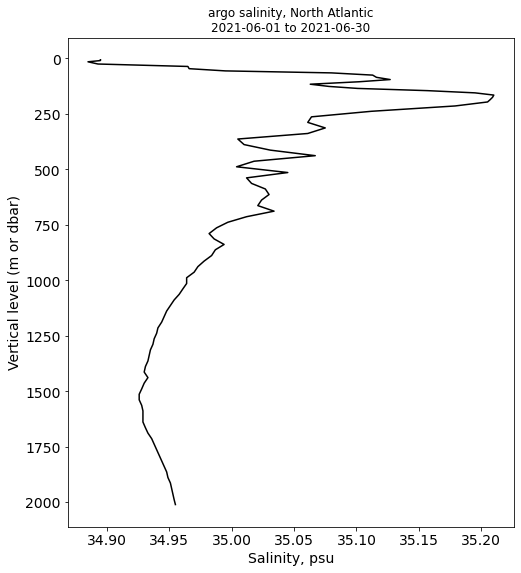

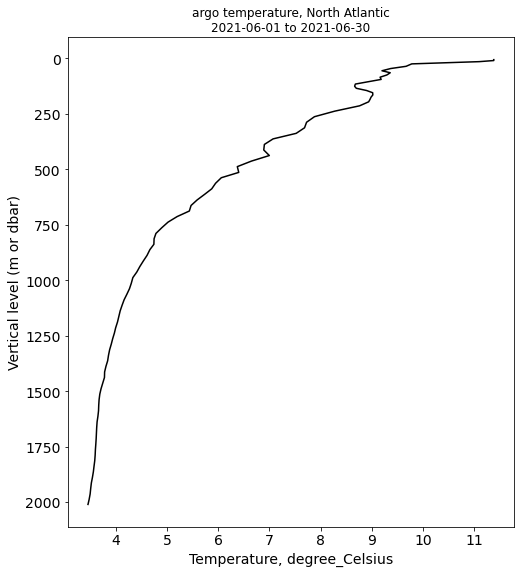

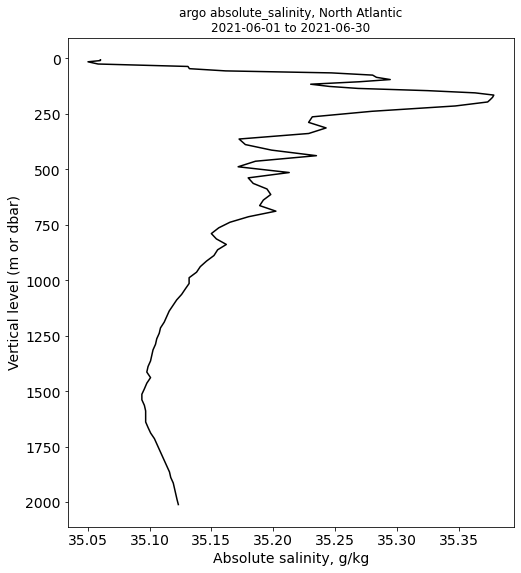

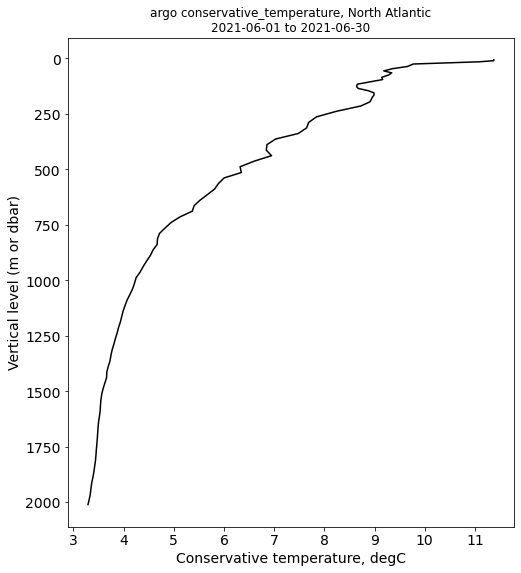

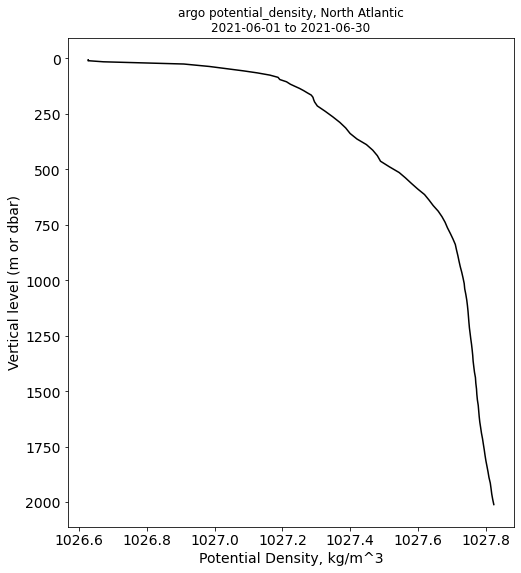

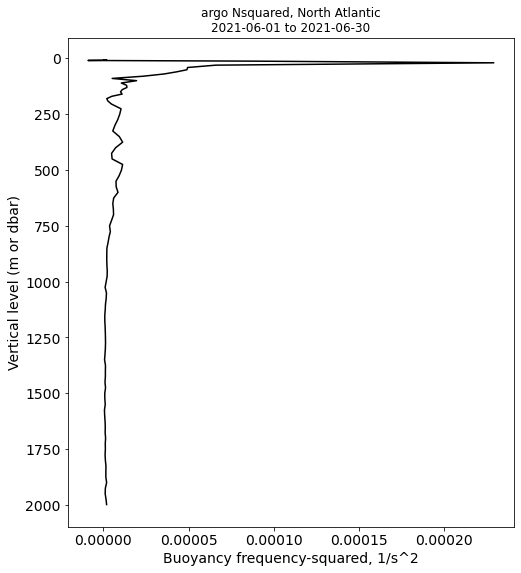

In [13]:
api_output_formatted_list_1var_plot_profiles(api_output_formatted_list_1profile)

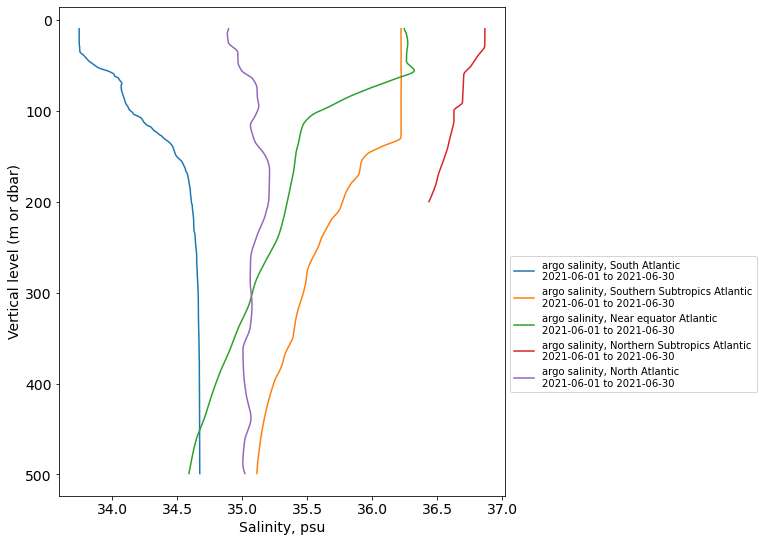

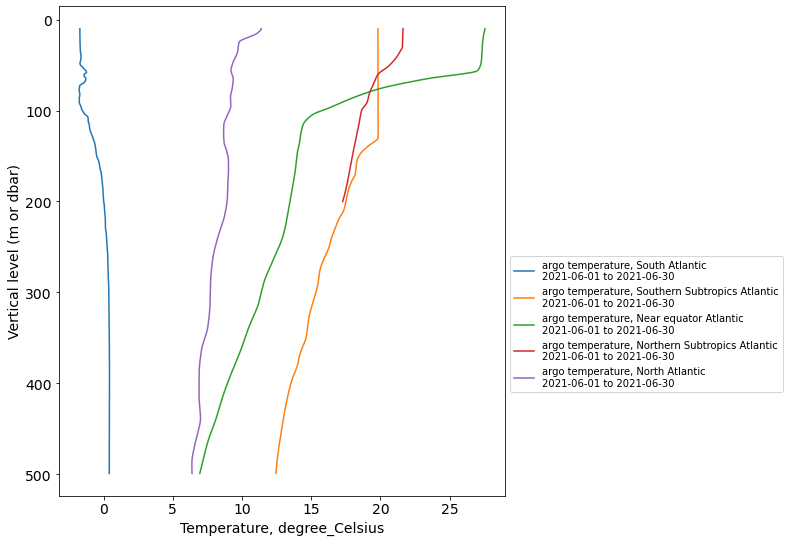

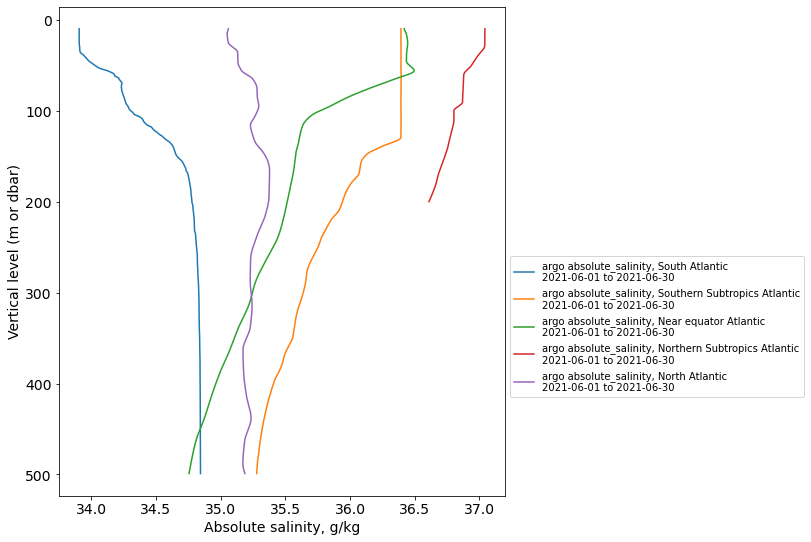

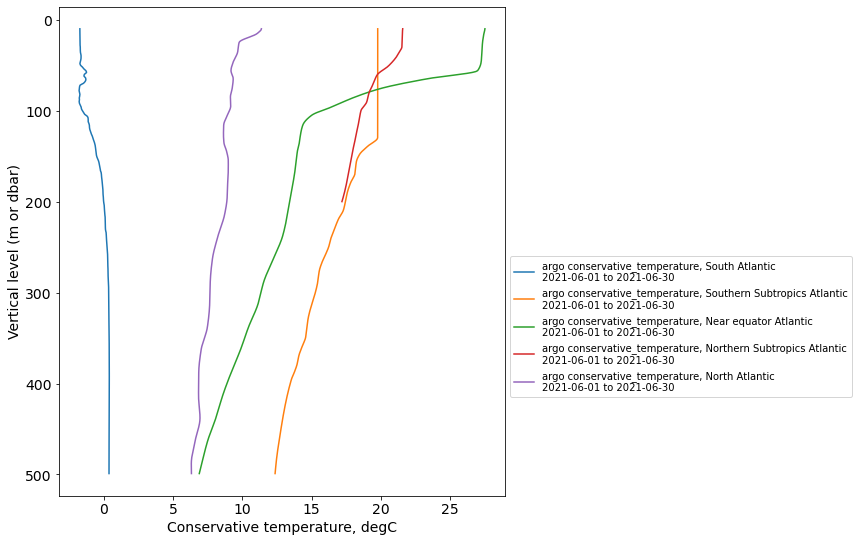

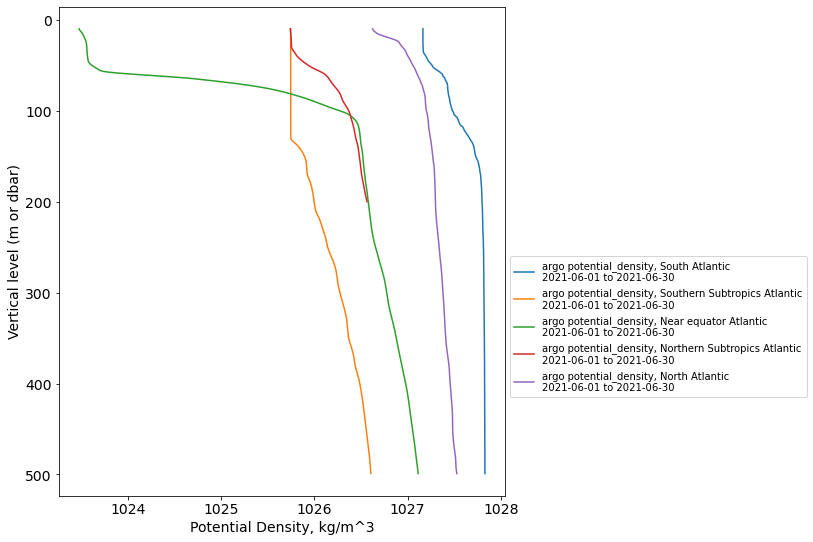

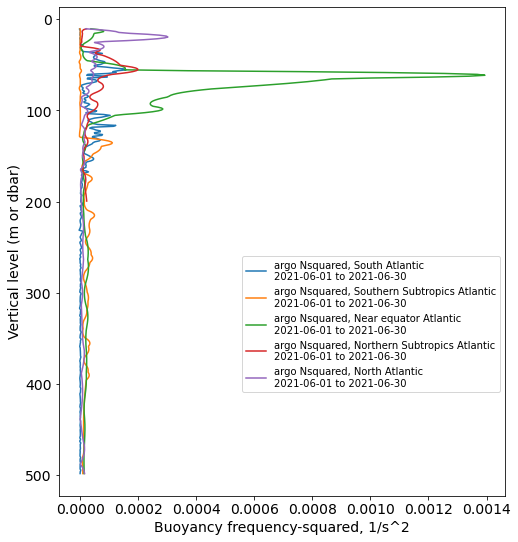

In [14]:
# if we had not moved forward with only one profile per region and time period of interest,
# the function below would perform the horizontal and time average of all the profiles available
# in that region and time period of interest
api_output_formatted_list_1var_plot_horizontal_and_time_ave(api_output_formatted_list_1profile,colors)  


In [15]:
# plt.plot(api_output_formatted_list_1profile[0]['temperature']['levels'][0],
#     api_output_formatted_list_1profile[0]['temperature']['data'][0],)
# plt.xlim(0,500)

In [16]:
# api_output_formatted_list_1profile[0]['temperature']['data_xarray']['data'].plot()

In [17]:
# import sys 
# sys.getsizeof(api_output_formatted_list) 

# Extra section: visualizing profiles from Argo platform and/or WOCE line

In the following, we will use some of the plots above to visualize profiles from a specific Argo platform and/or a WOCE line. In doing so, we will focus only on the object of interest (e.g. profiles from a specific Argo platform or WOCE line) and **NOT** select by region or time.

## Setup: define parameters to query data of interest

Let's indicate the collections of interest (i.e. what datasets in Argovis you would like to use as they include the oceanic property of interest) and the parameter of interest. The parameter of interest should be present in all the collections to consider (e.g. 'platform' is there for the Argo collection, yet 'woceline' is not there for Argo). We also list 1. all the variables that are available for each collection, and 2. all the values that are possible for the selected parameter (so that we can use the variable name and value of interest for the selected parameter, in following code cells). **Please first run the code with the current settings to familiarize yourself with the notebook: after that, if needed, then change the settings and run the notebook again.**

In [18]:
#+++

selection_params = {}

#+++ example for Argo platform
selection_params['collections']  = ['argo']
selection_params['parameter_name']= 'platform'
selection_params['varname_temperature'] = ['temperature']
selection_params['varname_salinity'] = ['salinity']
#+++

#+++ example for WOCE line from the Easyocean gridded product
selection_params['collections']  = ['easyocean','easyocean']
selection_params['parameter_name']= 'woceline'
selection_params['varname_temperature'] = ['ctd_temperature','ctd_temperature']
selection_params['varname_salinity'] = ['ctd_salinity','ctd_salinity']
#+++ 

# let's print to screen some info based on the selected collections (to be able to select further parameters in the next cells)
show_variable_names_for_collections(collections_list=selection_params['collections'],API_KEY=API_KEY,verbose=True)

values_for_param = list_values_for_parameter_to_api_query(selection_params=selection_params,API_KEY=API_KEY,verbose=False)


https://argovis-api.colorado.edu/easyocean/vocabulary?parameter=data
>>>>> easyocean
['pressure', 'ctd_temperature', 'ctd_salinity', 'doxy', 'conservative_temperature', 'absolute_salinity']
https://argovis-api.colorado.edu/easyocean/vocabulary?parameter=data
>>>>> easyocean
['pressure', 'ctd_temperature', 'ctd_salinity', 'doxy', 'conservative_temperature', 'absolute_salinity']


Let's list values available for the param of interest of interest.

In [19]:
for icollection in values_for_param.keys():
    print('---> ' + icollection)
    if len(values_for_param[icollection]['param_vals'])<100:
        print(values_for_param[icollection]['param_vals'])
    else:
        print('The list of param values is too long, will only show first 100 possible values')
        print(values_for_param[icollection]['param_vals'][0:100])


---> easyocean
['75N', 'A02', 'A03', 'A05', 'A10', 'A12', 'A13', 'A16-A23', 'A20', 'A22', 'A9.5', 'AR07E', 'AR07W', 'I01', 'I02', 'I03-I04', 'I05', 'I06S', 'I07', 'I08N', 'I08S-I09N', 'I09S', 'I10', 'IR06-I10', 'IR06E', 'IR06', 'P01', 'P02', 'P03', 'P04', 'P06', 'P09', 'P10', 'P11', 'P13', 'P14', 'P15', 'P16', 'P17E', 'P17', 'P18', 'P21', 'S04I', 'S04P', 'SR01', 'SR03', 'SR04']


For each collection, indicate the parameter value of interest, the variable of interest, and, if needed, the 'section_start_date' of interest (this is needed e.g. for Easyocean). Please note that a variable may not be available for some parameter values (e.g. many Argo platforms do not measure bgc variables). The code in the following will return no profiles if the selected variable is not available for the parameter value of interest.

In [20]:
#### parameters to set for each collection based on the info printed above

#+++ argo example
selection_params['parameter']     = ['4903274']
#+++ 

#+++  easyocean example
selection_params['parameter']     = ['P16','A16-A23'] #'P16', ['A10'] #['A16']
#+++

# based on the list above, let's set the section_start_date for the 'woceline' of interest:
# please note that if you don't edit below (see # +++*** after the if statement) the code 
# will select the latest occupation in the dataset
if selection_params['parameter_name']=='woceline':
    selection_params['section_start_date'] = []
    for i,icollection in enumerate(selection_params['collections']):
        print('>----> Occupations for selected woceline ' +selection_params['parameter'][i] + ':')
        print(values_for_param[icollection]['param_vals_extra'][selection_params['parameter'][i]]['time_boundaris'])
        print('--+ Selected occupation start date')
        bfr_param_vals_extra = values_for_param[icollection]['param_vals_extra'][selection_params['parameter'][i]]
        selection_params['section_start_date'].append(bfr_param_vals_extra['time_boundaris'][-1][0])#['2011-09-28T00:00:00.000Z']
        print(selection_params['section_start_date'])
        
# +++*** uncomment here to select the section start date manually
# selection_params['section_start_date'] = ['2005-01-10T00:00:00.000Z']

# define name of variable of interest for each collection

#+++ argo example
selection_params['varnames']     = ['doxy']
selection_params['varnames_qc']  = [',1'] # argoqc = 1 is best quality
#+++

#+++ easyocean example
selection_params['varnames']     = ['doxy','doxy']
selection_params['varnames_qc']  = ['',''] # woceqc = 2 is best quality
#+++

selection_params['varname_title']     = 'Oxygen, umol/kg'

# if we wanted to only consider oxygen profiles where temperature and salinity are qc 1, we would have here: 'temperature,1,salinity,1' (these additional variables are also stored for the regions of interest)
# (these additional variables are also stored for the regions of interest and visualized)
### please note that the first comma should be included!
### please note that qc flags are not used for Easyocean

#+++ argo example
selection_params['data_extra']   = [',temperature,1,salinity,1']
#+++

#+++ easyocean example
selection_params['data_extra']   = [',ctd_temperature,ctd_salinity',',ctd_temperature,ctd_salinity'] # we included these as we want to store them
#+++

# define name of the variable that includes levels for each collection
selection_params['varname_levels'] = ['pressure','pressure'] # 


>----> Occupations for selected woceline P16:
[['1991-03-10T00:00:00.000Z', '1992-10-28T00:00:00.000Z'], ['2005-01-10T00:00:00.000Z', '2006-03-30T00:00:00.000Z'], ['2014-03-31T00:00:00.000Z', '2015-06-18T00:00:00.000Z']]
--+ Selected occupation start date
['2014-03-31T00:00:00.000Z']
>----> Occupations for selected woceline A16-A23:
[['1988-07-23T00:00:00.000Z', '1989-04-08T00:00:00.000Z'], ['1993-07-07T00:00:00.000Z', '1993-08-28T00:00:00.000Z'], ['1995-03-30T00:00:00.000Z', '1998-05-23T00:00:00.000Z'], ['2003-06-20T00:00:00.000Z', '2005-02-21T00:00:00.000Z'], ['2011-07-20T00:00:00.000Z', '2011-07-31T00:00:00.000Z'], ['2013-08-03T00:00:00.000Z', '2014-01-29T00:00:00.000Z']]
--+ Selected occupation start date
['2014-03-31T00:00:00.000Z', '2013-08-03T00:00:00.000Z']


Finally, let's define the vertical levels that we want to use to interpolate observed profiles and colors to use for the line plots. 

In [21]:
# levels for vertically integrated profiles
selection_params['interp_levels']= list(range(10,501))[0::20]
# colors to use for the line plots
colors = list(mcolors.TABLEAU_COLORS.keys())

## Loading the data of interest using the Argovis API

In the next code cell, parameters selected above are used to query the data of interest and format them in a way that allows to easily visualize the data. Depending on the size of the data requested, the next code cell may take several minutes to complete.

In [22]:
api_output_formatted_list = get_api_output_formatted_list_1var_for_parameter(selection_params=selection_params,API_KEY=API_KEY)


QC flags are used only for Argo and CCHDO
doxy,ctd_temperature,ctd_salinity
https://argovis-api.colorado.edu/easyocean?data=doxy,ctd_temperature,ctd_salinity&woceline=P16&section_start_date=2014-03-31T00:00:00.000Z
QC flags are used only for Argo and CCHDO
doxy,ctd_temperature,ctd_salinity
https://argovis-api.colorado.edu/easyocean?data=doxy,ctd_temperature,ctd_salinity&woceline=A16-A23&section_start_date=2013-08-03T00:00:00.000Z


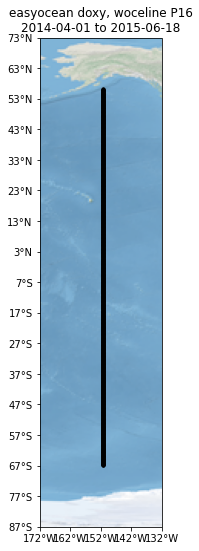

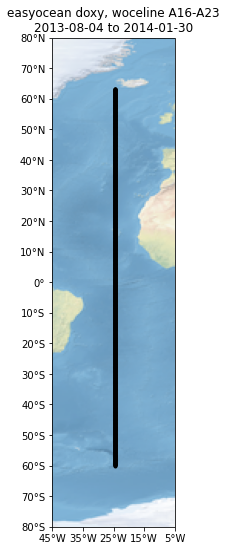

In [23]:
# plot map of lons and lats for data that are not gridded
api_output_formatted_list_1var_plot_lons_lats_map(api_output_formatted_list)
# example of how to change the figure size
# fig = plt.gcf() # gcf: get current figure
# fig.set_size_inches(10,15)


Let's compute e.g. potential density, N_squared, absolute salinity, conservative temperature from in-situ temperature and salinity and add it to items in the list api_output_formatted_list.

In [24]:
api_output_formatted_list = api_output_formatted_list_include_gsw_fields(list_fields_to_include=['absolute_salinity','conservative_temperature','potential_density','Nsquared'],
                                                        api_output_formatted_list0=api_output_formatted_list)


Now, let's create a shaded plot showing all the profiles (in an order based on a coordinate of interest, e.g. longitude, latitude, timestamp) and all the levels.

/Users/dgiglio/Work/code/giglio/Argovis_newAPI/demo_notebooks/work_in_progress/Argovis_tasks_helpers.py:588: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(i[ivar]['data_xarray'][var2use_for_sorting].values,i[ivar]['data_xarray'].coords['levels'].values,d2pl.values)


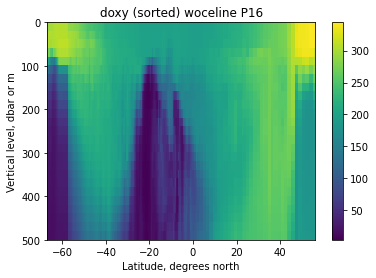

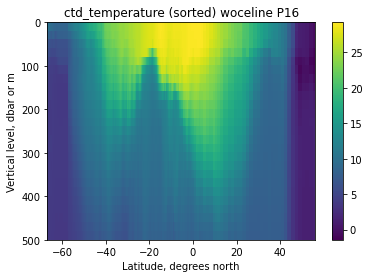

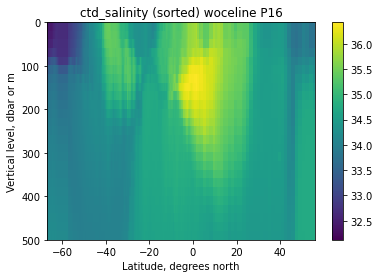

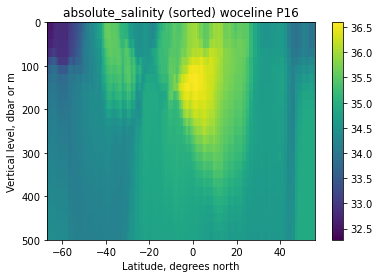

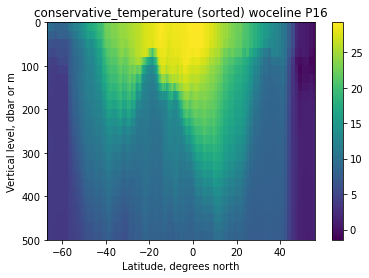

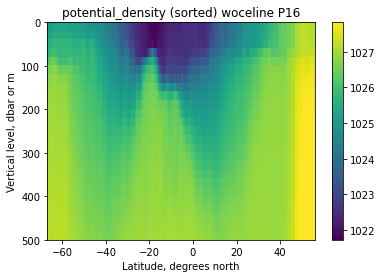

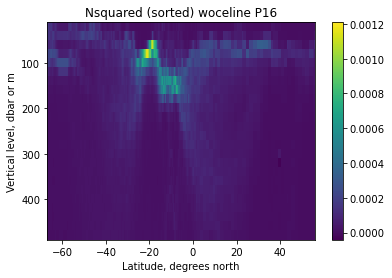

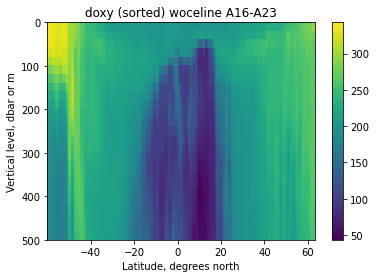

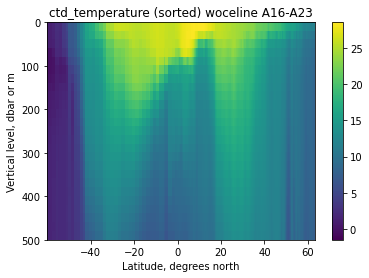

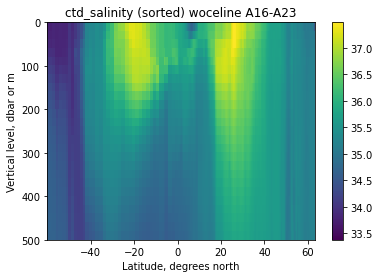

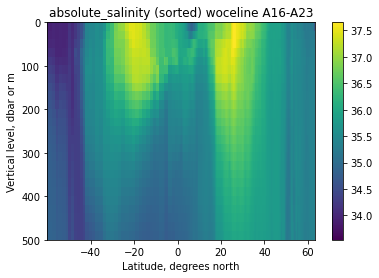

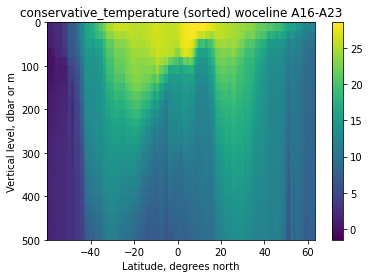

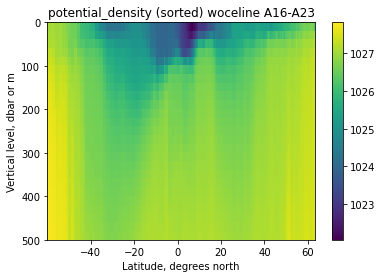

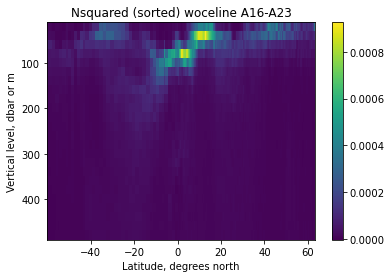

In [25]:
# select the variable of interest for the sorting:
# woceline: look at the map above and choose what makes most sense between longitude and latitude
# argo platform: 'timestamp' is generally a good choice; the cycle number would be good too, yet 
# it is not currently stored in api_output_formatted_list
var2use_for_sorting = 'latitude'

api_output_formatted_list_parameter_2d_plot(api_output_formatted_list,var2use_for_sorting=var2use_for_sorting)
